# Denoising Diffusion Probabilistic Models with MedNIST Dataset

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create
synthetic 2D images.

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239

TODO: Add Open in Colab

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import ignite" || pip install -q pytorch-ignite

%matplotlib inline

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from monai.engines import SupervisedEvaluator, SupervisedTrainer, PrepareBatch, default_prepare_batch
from monai.handlers import MeanAbsoluteError, MeanSquaredError, StatsHandler, ValidationHandler, from_engine
from ignite.contrib.handlers import ProgressBar

# TODO: Add right import reference after deployed
from generative.networks.nets import DiffusionModelUNet
from generative.schedulers import DDPMScheduler
from generative.inferers import DiffusionInferer

from typing import Dict, Mapping, Optional, Union

print_config()

MONAI version: 1.1.dev2239
Numpy version: 1.23.4
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 13b24fa92b9d98bd0dc6d5cdcb52504fd09e297b
MONAI __file__: /home/mark/Envs/gen2/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0+cu102
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmps12e4a3c


## Set deterministic training for reproducibility

In [4]:
set_determinism(0)

## Setup MedNIST Dataset and training and validation dataloaders
In this tutorial, we will train our models on the MedNIST dataset available on MONAI
(https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset). In order to train faster, we will select just
one of the available classes ("Hand"), resulting in a training set with 7999 2D images.

In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, progress=False, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]

2022-11-22 17:22:35,007 - INFO - Downloaded: /tmp/tmps12e4a3c/MedNIST.tar.gz
2022-11-22 17:22:35,076 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-22 17:22:35,077 - INFO - Writing into directory: /tmp/tmps12e4a3c.


Here we use transforms to augment the training dataset:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.

In [6]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)

Loading dataset: 100%|███████████████████████████████████████████████████████| 7999/7999 [00:04<00:00, 1885.37it/s]


In [15]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, progress=False, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=4)

ValueError: Root directory root_dir must be a directory.

### Visualisation of the training images

batch shape: (8, 1, 64, 64)


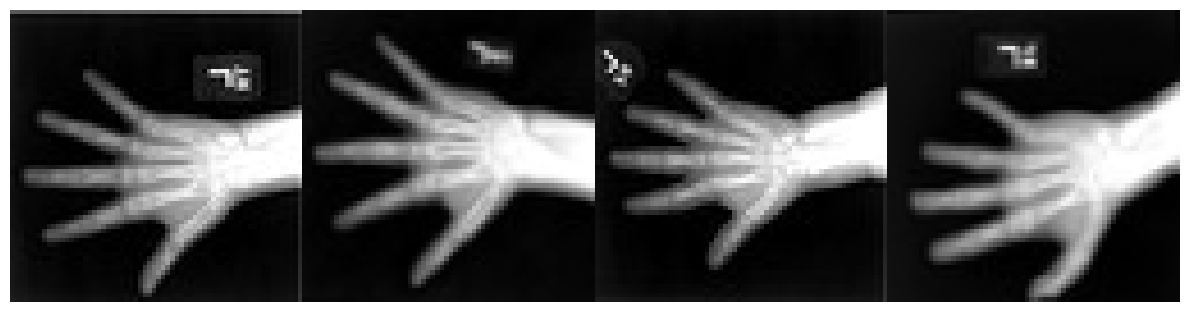

In [8]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 2nd and 3rd levels, each with 1 attention head.

In [9]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    model_channels=64,
    attention_resolutions=[2, 4],
    num_res_blocks=1,
    channel_mult=[1, 2, 2],
    num_heads=1,
)
model.to(device)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Define a class for preparing batches

In [10]:



class DiffusionPrepareBatch(PrepareBatch):
    """
    This class is used as a callable for the `prepare_batch` parameter of engine classes for diffusion training.

    Assuming a supervised training process, it will generate a noise field using `get_noise` for an input image, and
    return the image and noise field as the image/target pair plus the noise field the kwargs under the key "noise".
    This assumes the inferer being used in conjunction with this class expects a "noise" parameter to be provided.
    
    If the `condition_name` is provided, this must refer to a key in the input dictionary containing the condition
    field to be passed to the inferer. This will appear in the keyword arguments under the key "condition".
    
    """

    def __init__(self, condition_name: Optional[str] = None):
        self.condition_name = condition_name

    def get_noise(self, images):
        """Returns the noise tensor for input tensor `images`, override this for different noise distributions."""
        return torch.randn_like(images)

    def __call__(
        self,
        batchdata: Dict[str, torch.Tensor],
        device: Optional[Union[str, torch.device]] = None,
        non_blocking: bool = False,
        **kwargs,
    ):
        images, _ = default_prepare_batch(batchdata, device, non_blocking, **kwargs)
        noise = self.get_noise(images).to(device, non_blocking=non_blocking, **kwargs)

        kwargs = {"noise": noise}

        if self.condition_name is not None and isinstance(batchdata, Mapping):
            kwargs["conditioning"] = batchdata[self.condition_name].to(device, non_blocking=non_blocking, **kwargs)

        # return input, target, arguments, and keyword arguments where noise is the target and also a keyword value
        return images, noise, (), kwargs

### Model training
Here, we are training our model for 50 epochs (training time: ~20 minutes).

In [11]:



n_epochs = 20
val_interval = 5

val_handlers = [StatsHandler(name="train_log", output_transform=lambda x: None)]

evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=model,
    inferer=inferer,
    prepare_batch=DiffusionPrepareBatch(),
    key_val_metric={"val_mean_abs_error": MeanAbsoluteError(output_transform=from_engine(["pred", "label"]))},
    val_handlers=val_handlers,
)


train_handlers = [
    ValidationHandler(validator=evaluator, interval=val_interval, epoch_level=True),
    #StatsHandler(name="train_log", tag_name="train_loss", output_transform=from_engine(["loss"], first=True)),
]

trainer = SupervisedTrainer(
    device=device,
    max_epochs=n_epochs,
    train_data_loader=train_loader,
    network=model,
    optimizer=optimizer,
    loss_function=torch.nn.MSELoss(),
    inferer=inferer,
    prepare_batch=DiffusionPrepareBatch(),
    key_train_metric={"train_acc": MeanSquaredError(output_transform=from_engine(["pred", "label"]))},
    train_handlers=train_handlers,
)
ProgressBar(
            persist=True,
            bar_format="[{n_fmt}/{total_fmt}] {percentage:3.0f}%|{postfix} [{elapsed}<{remaining}]",
        ).attach(
            trainer,
            output_transform=from_engine(["loss"]),
        )


trainer.run()

2022-11-22 17:23:06,132 - Engine run resuming from iteration 0, epoch 0 until 20 epochs


[1/1000]   0%| [00:00<?]

/home/mark/Envs/gen2/lib/python3.8/site-packages/ignite/contrib/handlers/base_logger.py:172: UserWarning: Logger output_handler can not log metrics value type <class 'list'>
  warnings.warn(f"Logger output_handler can not log metrics value type {type(value)}")


2022-11-22 17:24:02,771 - Got new best metric of train_acc: 0.15793311595916748
2022-11-22 17:24:02,773 - Epoch[1] Complete. Time taken: 00:00:56.548


[1/1000]   0%| [00:00<?]

2022-11-22 17:25:01,106 - Epoch[2] Complete. Time taken: 00:00:58.333


[1/1000]   0%| [00:00<?]

2022-11-22 17:26:04,595 - Epoch[3] Complete. Time taken: 00:01:03.489


[1/1000]   0%| [00:00<?]

2022-11-22 17:27:11,009 - Epoch[4] Complete. Time taken: 00:01:06.413


[1/1000]   0%| [00:00<?]

2022-11-22 17:28:18,122 - Engine run resuming from iteration 0, epoch 4 until 5 epochs
2022-11-22 17:28:34,853 - Got new best metric of val_mean_abs_error: 0.055571842938661575
2022-11-22 17:28:34,853 - Epoch[5] Metrics -- val_mean_abs_error: 0.0556 
2022-11-22 17:28:34,854 - Key metric: val_mean_abs_error best value: 0.055571842938661575 at epoch: 5
2022-11-22 17:28:34,854 - Epoch[5] Complete. Time taken: 00:00:16.647
2022-11-22 17:28:34,854 - Engine run complete. Time taken: 00:00:16.732
2022-11-22 17:28:34,893 - Epoch[5] Complete. Time taken: 00:01:23.884


[1/1000]   0%| [00:00<?]

2022-11-22 17:29:42,501 - Epoch[6] Complete. Time taken: 00:01:07.607


[1/1000]   0%| [00:00<?]

2022-11-22 17:30:50,191 - Epoch[7] Complete. Time taken: 00:01:07.690


[1/1000]   0%| [00:00<?]

2022-11-22 17:31:57,836 - Epoch[8] Complete. Time taken: 00:01:07.644


[1/1000]   0%| [00:00<?]

2022-11-22 17:33:07,004 - Epoch[9] Complete. Time taken: 00:01:09.167


[1/1000]   0%| [00:00<?]

2022-11-22 17:34:15,174 - Engine run resuming from iteration 0, epoch 9 until 10 epochs
2022-11-22 17:34:32,451 - Epoch[10] Metrics -- val_mean_abs_error: 0.0505 
2022-11-22 17:34:32,452 - Key metric: val_mean_abs_error best value: 0.055571842938661575 at epoch: 5
2022-11-22 17:34:32,452 - Epoch[10] Complete. Time taken: 00:00:17.188
2022-11-22 17:34:32,452 - Engine run complete. Time taken: 00:00:17.278
2022-11-22 17:34:32,495 - Epoch[10] Complete. Time taken: 00:01:25.491


[1/1000]   0%| [00:00<?]

2022-11-22 17:35:43,044 - Epoch[11] Complete. Time taken: 00:01:10.548


[1/1000]   0%| [00:00<?]

2022-11-22 17:36:52,061 - Epoch[12] Complete. Time taken: 00:01:09.017


[1/1000]   0%| [00:00<?]

2022-11-22 17:38:03,117 - Epoch[13] Complete. Time taken: 00:01:11.055


[1/1000]   0%| [00:00<?]

2022-11-22 17:39:13,410 - Epoch[14] Complete. Time taken: 00:01:10.293


[1/1000]   0%| [00:00<?]

2022-11-22 17:40:24,312 - Engine run resuming from iteration 0, epoch 14 until 15 epochs
2022-11-22 17:40:41,691 - Epoch[15] Metrics -- val_mean_abs_error: 0.0489 
2022-11-22 17:40:41,692 - Key metric: val_mean_abs_error best value: 0.055571842938661575 at epoch: 5
2022-11-22 17:40:41,693 - Epoch[15] Complete. Time taken: 00:00:17.288
2022-11-22 17:40:41,693 - Engine run complete. Time taken: 00:00:17.380
2022-11-22 17:40:41,731 - Epoch[15] Complete. Time taken: 00:01:28.320


[1/1000]   0%| [00:00<?]

2022-11-22 17:41:52,933 - Epoch[16] Complete. Time taken: 00:01:11.202


[1/1000]   0%| [00:00<?]

2022-11-22 17:43:03,879 - Epoch[17] Complete. Time taken: 00:01:10.946


[1/1000]   0%| [00:00<?]

2022-11-22 17:44:14,105 - Epoch[18] Complete. Time taken: 00:01:10.225


[1/1000]   0%| [00:00<?]

2022-11-22 17:45:25,952 - Epoch[19] Complete. Time taken: 00:01:11.847


[1/1000]   0%| [00:00<?]

2022-11-22 17:46:36,380 - Engine run resuming from iteration 0, epoch 19 until 20 epochs
2022-11-22 17:46:53,882 - Epoch[20] Metrics -- val_mean_abs_error: 0.0491 
2022-11-22 17:46:53,883 - Key metric: val_mean_abs_error best value: 0.055571842938661575 at epoch: 5
2022-11-22 17:46:53,883 - Epoch[20] Complete. Time taken: 00:00:17.415
2022-11-22 17:46:53,883 - Engine run complete. Time taken: 00:00:17.503
2022-11-22 17:46:53,924 - Epoch[20] Complete. Time taken: 00:01:27.971
2022-11-22 17:46:53,925 - Engine run complete. Time taken: 00:23:47.793


### Plotting sampling process along DDPM's Markov chain

100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.33it/s]


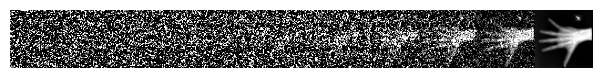

In [16]:
model.eval()
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image, intermediates = inferer.sample(
    input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
)

chain = torch.cat(intermediates, dim=-1)

plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)